### Compare tropical continental PFTs with standard tropical PFTs

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs

#import functions_py.fates_xarray_functions as fa

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pftnames = ['broadleaf_evergreen_tropical_americas_tree', 'broadleaf_evergreen_tropical_african_tree', 
            'broadleaf_evergreen_tropical_asian_tree','broadleaf_hydrodecid_tropical_americas_tree',
            'broadleaf_hydrodecid_tropical_african_tree', 'broadleaf_hydrodecid_tropical_asian_tree',
        'c4_grass']
print(len(pftnames))

7


In [3]:
def scpf_to_scls_by_pft(scpf_var, dataset):
    """function to reshape a fates multiplexed size and pft-indexed variable to one indexed by size class and pft
    first argument should be an xarray DataArray that has the FATES SCPF dimension
    second argument should be an xarray Dataset that has the FATES SCLS dimension 
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the size and pft dimensions disentangled"""
    n_scls = len(dataset.fates_levscls)
    ds_out = (scpf_var.rolling(fates_levscpf=n_scls, center=False)
            .construct("fates_levscls")
            .isel(fates_levscpf=slice(n_scls-1, None, n_scls))
            .rename({'fates_levscpf':'fates_levpft'})
            .assign_coords({'fates_levscls':dataset.fates_levscls})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    ds_out.attrs['long_name'] = scpf_var.attrs['long_name']
    ds_out.attrs['units'] = scpf_var.attrs['units']
    return(ds_out)

#### Load FATES runs

In [4]:
fates  = '/pscratch/sd/j/jneedham/elm_runs/tropical_fb/full_fates_tropical_v2.Ed9fb3dd6d4-Fe03fe142.2025-05-11/run/full_fates_tropical_v2.Ed9fb3dd6d4-Fe03fe142.2025-05-11.2010s.nc'
fates = xr.open_dataset(fates,  decode_times=False)

time = fates.variables['time'] / 365.
cohort_size_bins = fates.variables['fates_levscls'][:]
nsizebins = len(cohort_size_bins)

fates_ctr = '/pscratch/sd/j/jneedham/elm_runs/tropical_fb/full_fates_tropical_control.Ed9fb3dd6d4-Fe03fe142.2025-04-24/run/full_fates_tropical_control.Ed9fb3dd6d4-Fe03fe142.2025-04-24.2010s.nc'
fates_ctr = xr.open_dataset(fates_ctr, decode_times=False)

In [5]:
tave_start=len(time) - 12*10
tave_stop=len(time)

print(tave_start)
print(tave_stop)

0
120


In [6]:
vegc_pf = fates.FATES_VEGC_PF.isel(time=slice(tave_start,  tave_stop)).mean(dim='time')
vegc_pf_ctr = fates_ctr.FATES_VEGC_PF.isel(time=slice(tave_start,  tave_stop)).mean(dim='time')

### Sanity check of PFT distributuions

(0.0, 1.0, 0.0, 1.0)

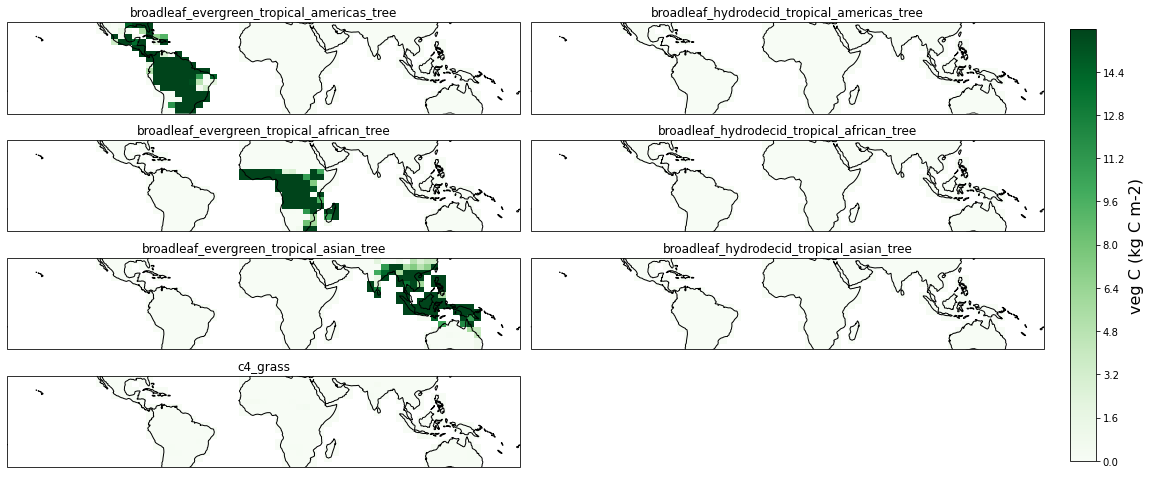

In [7]:
order = [0,2,4,1,3,5,6]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,16.0,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10))
axs=axs.flatten()
for i in range(0,7):
        cs= vegc_pf.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens', ax=axs[order[i]],add_colorbar=False)
        axs[order[i]].set_title(pftnames[i])
        axs[order[i]].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('veg C (kg C m-2)', size=16)

axs[7].axis('off')

### Aboveground Biomass 

In [8]:
fates_agb = (fates.FATES_VEGC_ABOVEGROUND_SZPF.sum(dim='fates_levscpf')).mean(dim='time') * fates.FATES_FRACTION.mean(dim='time')
fates_ctr_agb = (fates_ctr.FATES_VEGC_ABOVEGROUND_SZPF.sum(dim='fates_levscpf')).mean(dim='time') * fates_ctr.FATES_FRACTION.mean(dim='time')

In [9]:
agb_ds =  '/pscratch/sd/j/jneedham/ILAMB/DATA/biomass/XuSaatchi2021/XuSaatchi.nc'
agb_ds = xr.open_dataset(agb_ds, decode_times=False)

nyears = int(len(agb_ds.variables['time'])/12)
tstart = (nyears-10)*12
tstop  = nyears*12

agb = agb_ds.biomass
agb = agb.isel(time=slice(tstart, tstop)).mean(dim='time') 

# convert from Mg ha-1 to kg m-2 
agb = agb/10

In [10]:
# Cut to just the tropics
cropped_agb = agb.sel(lat=slice(30,-30))
# Regrid to 4x5 degree resolution
new_lon = np.linspace(cropped_agb.lon[0], cropped_agb.lon[-1], fates_agb.sizes['lon'])
new_lat = np.linspace(cropped_agb.lat[0], cropped_agb.lat[-1], fates_agb.sizes['lat'])
agb_regrid = cropped_agb.interp(lat=new_lat,lon=new_lon)


In [11]:
fates_agb = fates_agb.assign_coords(lon=(((fates_agb.lon + 180) % 360) - 180))
fates_agb = fates_agb.sortby(fates_agb.lon)
fates_agb = fates_agb.isel(lat=slice(None,None,-1))

fates_ctr_agb = fates_ctr_agb.assign_coords(lon=(((fates_ctr_agb.lon + 180) % 360) - 180))
fates_ctr_agb = fates_ctr_agb.sortby(fates_ctr_agb.lon)
fates_ctr_agb = fates_ctr_agb.isel(lat=slice(None,None,-1))


In [12]:
fates_agb = fates_agb.assign_coords({'lon':agb_regrid.coords['lon']})
fates_agb = fates_agb.assign_coords({'lat':agb_regrid.coords['lat']})

fates_ctr_agb = fates_ctr_agb.assign_coords({'lon':agb_regrid.coords['lon']})
fates_ctr_agb = fates_ctr_agb.assign_coords({'lat':agb_regrid.coords['lat']})

In [13]:
diff  = agb_regrid - fates_agb
diff_ctr = agb_regrid - fates_ctr_agb

diff_fates = fates_ctr_agb - fates_agb

''

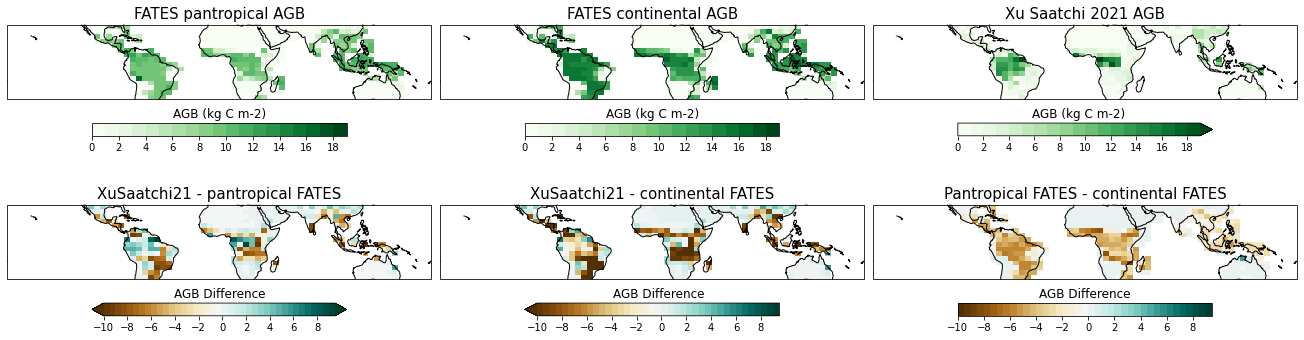

In [14]:
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,5),constrained_layout=True)

clevs = np.arange(0.,20,1)
axs=axs.flatten()

cs = fates_ctr_agb.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[0], add_colorbar=False)
axs[0].coastlines()
axs[0].set_title('FATES pantropical AGB', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[0], location='bottom',shrink=0.6)
cbar.ax.set_title("AGB (kg C m-2)")

cs = fates_agb.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[1], add_colorbar=False)
axs[1].coastlines()
axs[1].set_title('FATES continental AGB', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[1], location='bottom',shrink=0.6)
cbar.ax.set_title("AGB (kg C m-2)")

cs = agb_regrid.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[2], add_colorbar=False)
axs[2].coastlines()
axs[2].set_title('Xu Saatchi 2021 AGB', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[2], location='bottom',shrink=0.6)
cbar.ax.set_title("AGB (kg C m-2)")

clevs = np.arange(-10,10,0.5)
cs = diff_ctr.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[3], add_colorbar=False)
axs[3].coastlines()
axs[3].set_title('XuSaatchi21 - pantropical FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[3], location='bottom',shrink=0.6)
cbar.ax.set_title("AGB Difference")


cs = diff.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[4], add_colorbar=False)
axs[4].coastlines()
axs[4].set_title('XuSaatchi21 - continental FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[4], location='bottom',shrink=0.6)
cbar.ax.set_title("AGB Difference")

cs = diff_fates.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[5], add_colorbar=False)
axs[5].coastlines()
axs[5].set_title('Pantropical FATES - continental FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[5], location='bottom',shrink=0.6)
cbar.ax.set_title("AGB Difference")

;

### Burn fraction 

In [15]:
burnfrac = fates.FATES_BURNFRAC.mean(dim='time') * 86400 * 365 * fates.FATES_FRACTION.mean(dim='time') # convert to burned area frac per year 
burnfrac_ctr = fates_ctr.FATES_BURNFRAC.mean(dim='time') * 86400 * 365 * fates_ctr.FATES_FRACTION.mean(dim='time') # convert to burned area frac per year 


In [16]:
bf_ds =  '/pscratch/sd/j/jneedham/ILAMB/DATA/burntArea/GFED4.1S/burntArea.nc'
bf_ds = xr.open_dataset(bf_ds, decode_times=False)

nyears = int(len(bf_ds.variables['time'])/12)
tstart = (nyears-10)*12
tstop  = nyears*12

bf = bf_ds.burntArea
bf = bf.isel(time=slice(tstart, tstop)).mean(dim='time') 

print(bf.shape)

(360, 720)


In [17]:
# Cut to just the tropics
cropped_bf = bf.sel(lat=slice(-30,30))
print(cropped_bf.shape)
# Regrid to 4x5 degree resolution
new_lon = np.linspace(cropped_bf.lon[0], cropped_bf.lon[-1], burnfrac.sizes['lon'])
new_lat = np.linspace(cropped_bf.lat[0], cropped_bf.lat[-1], burnfrac.sizes['lat'])
bf_regrid = cropped_bf.interp(lat=new_lat,lon=new_lon)


(120, 720)


In [18]:
fates_bf = burnfrac.assign_coords(lon=(((burnfrac.lon + 180) % 360) - 180))
fates_bf = fates_bf.sortby(fates_bf.lon)

fates_ctr_bf = burnfrac_ctr.assign_coords(lon=(((burnfrac_ctr.lon + 180) % 360) - 180))
fates_ctr_bf = fates_ctr_bf.sortby(fates_ctr_bf.lon)


In [19]:
fates_bf = fates_bf.assign_coords({'lon':bf_regrid.coords['lon']})
fates_bf = fates_bf.assign_coords({'lat':bf_regrid.coords['lat']})

fates_ctr_bf = fates_ctr_bf.assign_coords({'lon':bf_regrid.coords['lon']})
fates_ctr_bf = fates_ctr_bf.assign_coords({'lat':bf_regrid.coords['lat']})

In [20]:
diff  = bf_regrid - fates_bf
diff_ctr = bf_regrid - fates_ctr_bf

diff_fates = fates_ctr_bf - fates_bf

''

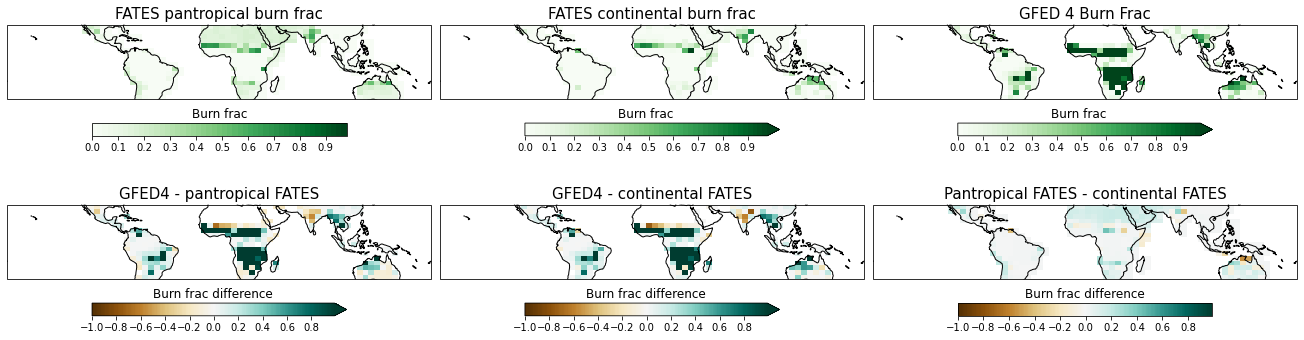

In [21]:
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,5),constrained_layout=True)

clevs = np.arange(0.,1,0.02)
axs=axs.flatten()

cs = fates_ctr_bf.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[0], add_colorbar=False)
axs[0].coastlines()
axs[0].set_title('FATES pantropical burn frac', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[0], location='bottom',shrink=0.6)
cbar.ax.set_title("Burn frac")

cs = fates_bf.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[1], add_colorbar=False)
axs[1].coastlines()
axs[1].set_title('FATES continental burn frac', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[1], location='bottom',shrink=0.6)
cbar.ax.set_title("Burn frac")

cs = bf_regrid.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[2], add_colorbar=False)
axs[2].coastlines()
axs[2].set_title('GFED 4 Burn Frac', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[2], location='bottom',shrink=0.6)
cbar.ax.set_title("Burn frac")

clevs = np.arange(-1,1,0.01)
cs = diff_ctr.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[3], add_colorbar=False)
axs[3].coastlines()
axs[3].set_title('GFED4 - pantropical FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[3], location='bottom',shrink=0.6)
cbar.ax.set_title("Burn frac difference")


cs = diff.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[4], add_colorbar=False)
axs[4].coastlines()
axs[4].set_title('GFED4 - continental FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[4], location='bottom',shrink=0.6)
cbar.ax.set_title("Burn frac difference")

cs = diff_fates.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[5], add_colorbar=False)
axs[5].coastlines()
axs[5].set_title('Pantropical FATES - continental FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[5], location='bottom',shrink=0.6)
cbar.ax.set_title("Burn frac difference")

;

### Veg C 

In [22]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,35,0.5)

fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(10,10), constrained_layout=True)

cs= vegc_pf_ctr.sum(dim='fates_levpft').plot(levels=clevs,cmap='Greens', ax=axs[0],add_colorbar=False)
axs[0].set_title('Pantropical', fontsize=20)
axs[0].coastlines()
cbar = fig.colorbar(cs, ax=axs[0], location='bottom',shrink=0.6)
cbar.ax.set_title("Vegetation Carbon (kg C m-2)")

cs= vegc_pf.sum(dim='fates_levpft').plot(levels=clevs,cmap='Greens', ax=axs[1],add_colorbar=False)
axs[1].set_title('Continental', fontsize=20)
axs[1].coastlines()
cbar=fig.colorbar(cs, ax=axs[1], location='bottom',shrink=0.6)
cbar.ax.set_title("Vegetation Carbon (kg C m-2)")

diff = vegc_pf_ctr.sum(dim='fates_levpft') - vegc_pf.sum(dim='fates_levpft')

clevs=np.arange(-15,15,0.1)
cs= diff.plot(levels=clevs,cmap='RdBu', ax=axs[2],add_colorbar=False)
axs[2].set_title('Panropical - Continental', fontsize=20)
axs[2].coastlines()
cbar=fig.colorbar(cs, ax=axs[2], location='bottom',shrink=0.6)
cbar.ax.set_title("Difference in Vegetation Carbon (kg C m-2)")

Text(0.5, 1.0, 'Difference in Vegetation Carbon (kg C m-2)')

### LAI 

In [23]:
fates_lai = fates.FATES_LAI.isel(time=slice(tave_start,  tave_stop)).mean(dim='time') * fates.FATES_FRACTION.mean(dim='time')
fates_ctr_lai = fates_ctr.FATES_LAI.isel(time=slice(tave_start,  tave_stop)).mean(dim='time') * fates_ctr.FATES_FRACTION.mean(dim='time')

In [24]:
lai_ds =  '/pscratch/sd/j/jneedham/ILAMB/DATA/lai/MODIS/lai_0.5x0.5.nc'
lai_ds = xr.open_dataset(lai_ds, decode_times=False)

nyears = int(len(lai_ds.variables['time'])/12)
tstart = (nyears-10)*12
tstop  = nyears*12

lai = lai_ds.lai
lai = lai.isel(time=slice(tstart, tstop)).mean(dim='time') 


/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'lai' has multiple fill values {1e+36, -999.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [25]:
lai.coords

Coordinates:
  * lat      (lat) float32 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float32 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8

In [26]:
# Cut to just the tropics
cropped_lai = lai.sel(lat=slice(-30,30))
# Regrid to 4x5 degree resolution
new_lon = np.linspace(cropped_lai.lon[0], cropped_lai.lon[-1], fates_lai.sizes['lon'])
new_lat = np.linspace(cropped_lai.lat[0], cropped_lai.lat[-1], fates_lai.sizes['lat'])
lai_regrid = cropped_lai.interp(lat=new_lat,lon=new_lon)


In [27]:
fates_lai = fates_lai.assign_coords(lon=(((fates_lai.lon + 180) % 360) - 180))
fates_lai = fates_lai.sortby(fates_lai.lon)

fates_ctr_lai = fates_ctr_lai.assign_coords(lon=(((fates_ctr_lai.lon + 180) % 360) - 180))
fates_ctr_lai = fates_ctr_lai.sortby(fates_ctr_lai.lon)


In [28]:
fates_lai = fates_lai.assign_coords({'lon':lai_regrid.coords['lon']})
fates_lai = fates_lai.assign_coords({'lat':lai_regrid.coords['lat']})

fates_ctr_lai = fates_ctr_lai.assign_coords({'lon':lai_regrid.coords['lon']})
fates_ctr_lai = fates_ctr_lai.assign_coords({'lat':lai_regrid.coords['lat']})

In [29]:
diff  = lai_regrid - fates_lai
diff_ctr = lai_regrid - fates_ctr_lai

diff_fates = fates_ctr_lai - fates_lai

In [30]:
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,5),constrained_layout=True)

clevs = np.arange(0.,8,0.2)
axs=axs.flatten()

cs = fates_ctr_lai.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[0], add_colorbar=False)
axs[0].coastlines()
axs[0].set_title('FATES pantropical LAI', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[0], location='bottom',shrink=0.6)
cbar.ax.set_title("LAI (kg C m-2)")

cs = fates_lai.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[1], add_colorbar=False)
axs[1].coastlines()
axs[1].set_title('FATES continental LAI', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[1], location='bottom',shrink=0.6)
cbar.ax.set_title("LAI (kg C m-2)")

cs = lai_regrid.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[2], add_colorbar=False)
axs[2].coastlines()
axs[2].set_title('Modis LAI', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[2], location='bottom',shrink=0.6)
cbar.ax.set_title("LAI (kg C m-2)")

clevs = np.arange(-3,3,0.5)
cs = diff_ctr.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[3], add_colorbar=False)
axs[3].coastlines()
axs[3].set_title('Modis - pantropical FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[3], location='bottom',shrink=0.6)
cbar.ax.set_title("LAI Difference")


cs = diff.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[4], add_colorbar=False)
axs[4].coastlines()
axs[4].set_title('Modis - continental FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[4], location='bottom',shrink=0.6)
cbar.ax.set_title("LAI Difference")

cs = diff_fates.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[5], add_colorbar=False)
axs[5].coastlines()
axs[5].set_title('Pantropical FATES - continental FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[5], location='bottom',shrink=0.6)
cbar.ax.set_title("LAI Difference")

;

''

### ET 

In [31]:
# FATES units are mm/s - this is the same as kg /m-2
fates_et = (fates.QVEGE+fates.QVEGT+fates.QSOIL).mean(dim='time') * 86400 * 365
fates_ctr_et = (fates_ctr.QVEGE+fates_ctr.QVEGT+fates_ctr.QSOIL).mean(dim='time') * 86400 * 365

In [32]:
modis_et_ds =  '/pscratch/sd/j/jneedham/ILAMB/DATA/evspsbl/MODIS/et_0.5x0.5.nc'
modis_et_ds = xr.open_dataset(modis_et_ds, decode_times=False)

nyears = int(len(modis_et_ds.variables['time'])/12)
tstart = (nyears-10)*12
tstop  = nyears*12

modis_et = modis_et_ds.et
modis_et = modis_et.isel(time=slice(tstart, tstop)).mean(dim='time') * 86400 * 365

print(modis_et.shape)

(360, 720)


In [33]:
# Cut to just the tropics
cropped_modis_et = modis_et.sel(lat=slice(-30,30))
# Regrid to 4x5 degree resolution
new_lon = np.linspace(cropped_modis_et.lon[0], cropped_modis_et.lon[-1], fates_et.sizes['lon'])
new_lat = np.linspace(cropped_modis_et.lat[0], cropped_modis_et.lat[-1], fates_et.sizes['lat'])
modis_et_regrid = modis_et.interp(lat=new_lat,lon=new_lon)


In [34]:
fates_et = fates_et.assign_coords(lon=(((fates_et.lon + 180) % 360) - 180))
fates_et = fates_et.sortby(fates_et.lon)

fates_ctr_et = fates_ctr_et.assign_coords(lon=(((fates_ctr_et.lon + 180) % 360) - 180))
fates_ctr_et = fates_ctr_et.sortby(fates_ctr_et.lon)

In [35]:
fates_et = fates_et.assign_coords({'lon':modis_et_regrid.coords['lon']})
fates_et = fates_et.assign_coords({'lat':modis_et_regrid.coords['lat']})

fates_ctr_et = fates_ctr_et.assign_coords({'lon':modis_et_regrid.coords['lon']})
fates_ctr_et = fates_ctr_et.assign_coords({'lat':modis_et_regrid.coords['lat']})

In [36]:
diff  = modis_et_regrid - fates_et
diff_ctr = modis_et_regrid - fates_ctr_et

diff_fates = fates_ctr_et - fates_et

''

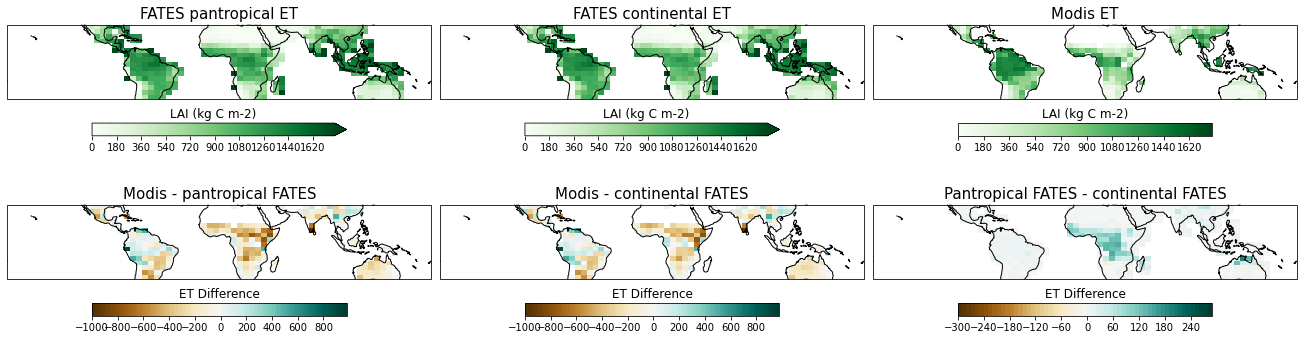

In [37]:
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,5),constrained_layout=True)

clevs = np.arange(0.,1800,20)
axs=axs.flatten()

cs = fates_ctr_et.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[0], add_colorbar=False)
axs[0].coastlines()
axs[0].set_title('FATES pantropical ET', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[0], location='bottom',shrink=0.6)
cbar.ax.set_title("LAI (kg C m-2)")

cs = fates_et.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[1], add_colorbar=False)
axs[1].coastlines()
axs[1].set_title('FATES continental ET', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[1], location='bottom',shrink=0.6)
cbar.ax.set_title("LAI (kg C m-2)")

cs = modis_et_regrid.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='Greens',
         ax=axs[2], add_colorbar=False)
axs[2].coastlines()
axs[2].set_title('Modis ET', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[2], location='bottom',shrink=0.6)
cbar.ax.set_title("LAI (kg C m-2)")

clevs = np.arange(-1000,1000,20)
cs = diff_ctr.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[3], add_colorbar=False)
axs[3].coastlines()
axs[3].set_title('Modis - pantropical FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[3], location='bottom',shrink=0.6)
cbar.ax.set_title("ET Difference")


cs = diff.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[4], add_colorbar=False)
axs[4].coastlines()
axs[4].set_title('Modis - continental FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[4], location='bottom',shrink=0.6)
cbar.ax.set_title("ET Difference")

clevs = np.arange(-300,300,10)
cs = diff_fates.plot(levels=clevs, transform=ccrs.PlateCarree(),cmap='BrBG',
         ax=axs[5], add_colorbar=False)
axs[5].coastlines()
axs[5].set_title('Pantropical FATES - continental FATES', fontsize=15)
cbar = fig.colorbar(cs, ax=axs[5], location='bottom',shrink=0.6)
cbar.ax.set_title("ET Difference")

;

### AGB by  PFT

In [38]:
order = [0,2,4,1,3,5,6]

In [39]:
vegc_pf = fates.FATES_VEGC_PF
recr = fates.FATES_RECRUITMENT_PF
seed_bank = fates.FATES_SEED_BANK

In [40]:
vegc_pf = fates.FATES_VEGC_PF.mean(dim='time')
recr_pf = fates.FATES_RECRUITMENT_PF.mean(dim='time')


(0.0, 1.0, 0.0, 1.0)

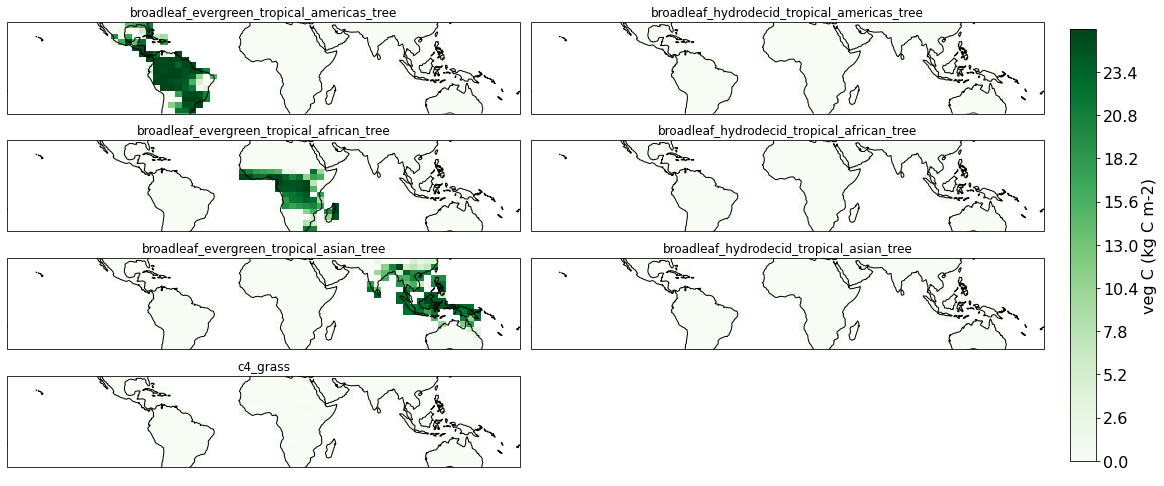

In [41]:
order = [0,2,4,1,3,5,6]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,26.0,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10))
axs=axs.flatten()
for i in range(0,7):
        cs= vegc_pf.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens', ax=axs[order[i]],add_colorbar=False)
        axs[order[i]].set_title(pftnames[i])
        axs[order[i]].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('veg C (kg C m-2)', size=16)
cbar.ax.tick_params(labelsize=16)

axs[7].axis('off')

(3, 16, 72)


(0.0, 1.0, 0.0, 1.0)

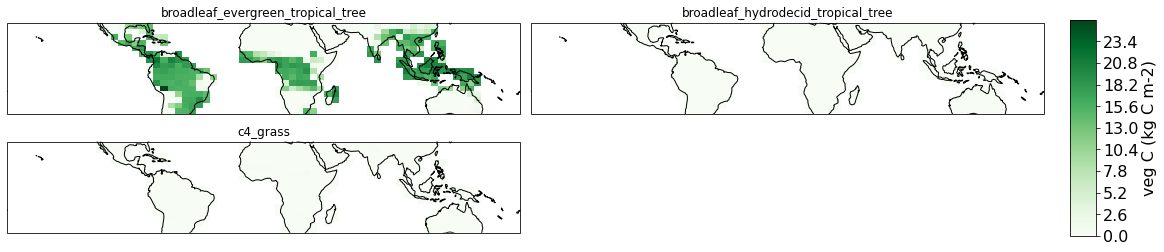

In [42]:
vegc_pft_ctr = fates_ctr.FATES_VEGC_PF.mean(dim='time')
print(vegc_pft_ctr.shape)
pftnames_ctr = ['broadleaf_evergreen_tropical_tree','broadleaf_hydrodecid_tropical_tree','c4_grass']

# Define the contour levels to use in plt.contourf
clevs=np.arange(0,26.0,0.01)
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,5))
axs=axs.flatten()
for i in range(0,3):
        cs= vegc_pf_ctr.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
        axs[i].set_title(pftnames_ctr[i])
        axs[i].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('veg C (kg C m-2)', size=16)
cbar.ax.tick_params(labelsize=16)

axs[3].axis('off')

(0.0, 1.0, 0.0, 1.0)

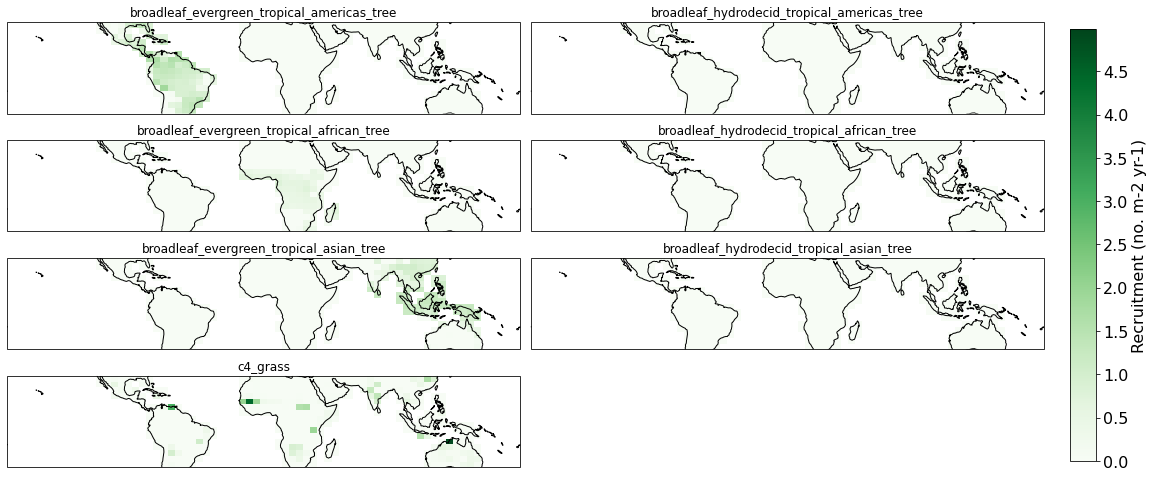

In [43]:
order = [0,2,4,1,3,5,6]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,5.0,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10))
axs=axs.flatten()
for i in range(0,7):
        cs= recr_pf.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens', ax=axs[order[i]],add_colorbar=False)
        axs[order[i]].set_title(pftnames[i])
        axs[order[i]].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Recruitment (no. m-2 yr-1)', size=16)
cbar.ax.tick_params(labelsize=16)
axs[7].axis('off')

### Hydraulic mortality 

In [44]:
hmort = scpf_to_scls_by_pft(fates.FATES_MORTALITY_HYDRAULIC_SZPF, fates).sum(dim='fates_levscls')
nplant = scpf_to_scls_by_pft(fates.FATES_NPLANT_SZPF, fates).sum(dim='fates_levscls')

hmort = hmort/nplant
hmort = hmort.mean(dim='time')

print(hmort.shape)

(7, 16, 72)


(0.0, 1.0, 0.0, 1.0)

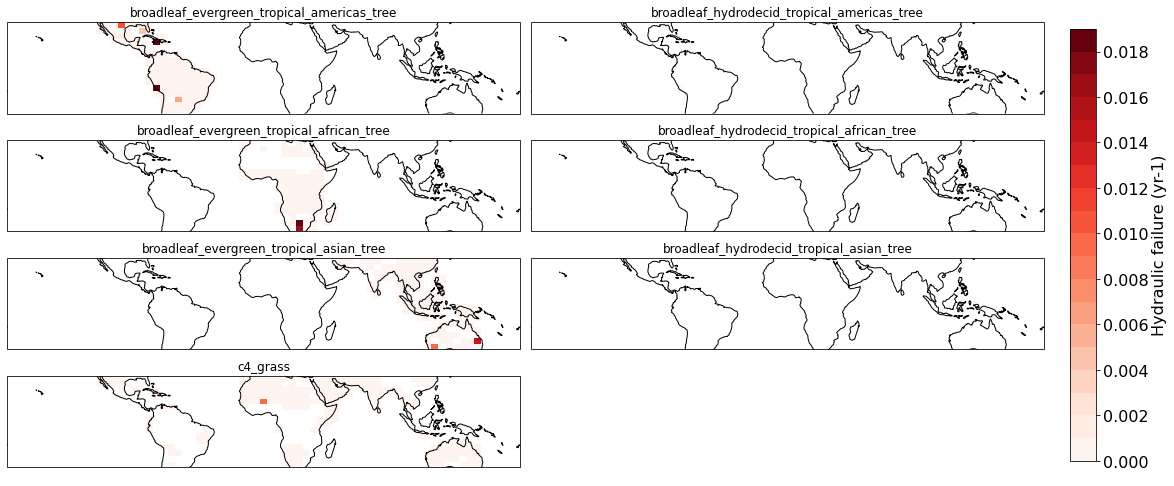

In [45]:
order = [0,2,4,1,3,5,6]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,0.02,0.001)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10))
axs=axs.flatten()
for i in range(0,7):
        cs= hmort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds', ax=axs[order[i]],add_colorbar=False)
        axs[order[i]].set_title(pftnames[i])
        axs[order[i]].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Hydraulic failure (yr-1)', size=16)
cbar.ax.tick_params(labelsize=16)
axs[7].axis('off')

In [46]:
cmort = scpf_to_scls_by_pft(fates.FATES_MORTALITY_CSTARV_SZPF, fates).sum(dim='fates_levscls')
nplant = scpf_to_scls_by_pft(fates.FATES_NPLANT_SZPF, fates).sum(dim='fates_levscls')

cmort = cmort/nplant
cmort = cmort.mean(dim='time')

print(cmort.shape)

(7, 16, 72)


(0.0, 1.0, 0.0, 1.0)

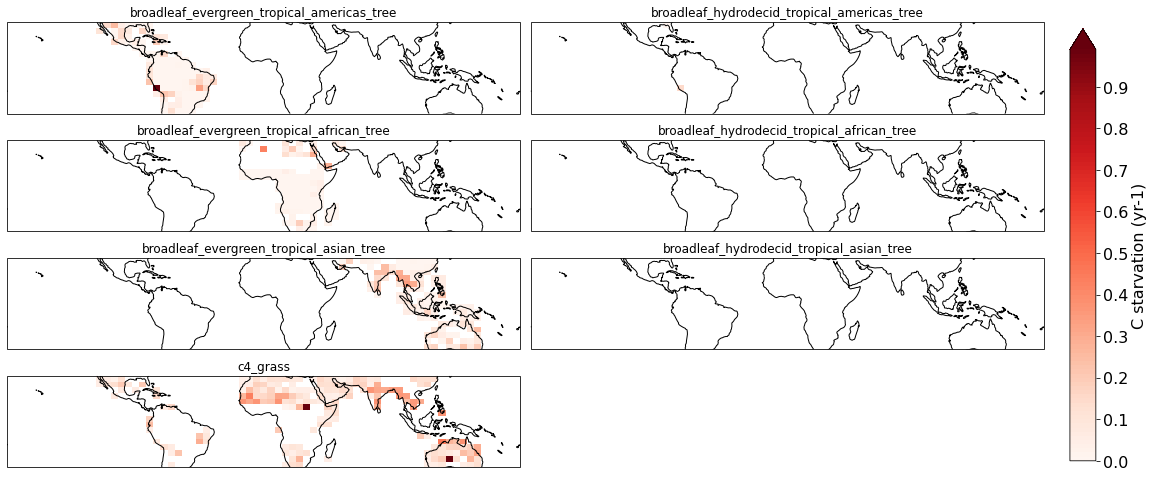

In [47]:
order = [0,2,4,1,3,5,6]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,1.0,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10))
axs=axs.flatten()
for i in range(0,7):
        cs= cmort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds', ax=axs[order[i]],add_colorbar=False)
        axs[order[i]].set_title(pftnames[i])
        axs[order[i]].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('C starvation (yr-1)', size=16)
cbar.ax.tick_params(labelsize=16)

axs[7].axis('off')

In [48]:
fmort = scpf_to_scls_by_pft(fates.FATES_MORTALITY_FIRE_SZPF, fates).sum(dim='fates_levscls')
nplant = scpf_to_scls_by_pft(fates.FATES_NPLANT_SZPF, fates).sum(dim='fates_levscls')

fmort = fmort/nplant
fmort = fmort.mean(dim='time')

print(fmort.shape)

(7, 16, 72)


(0.0, 1.0, 0.0, 1.0)

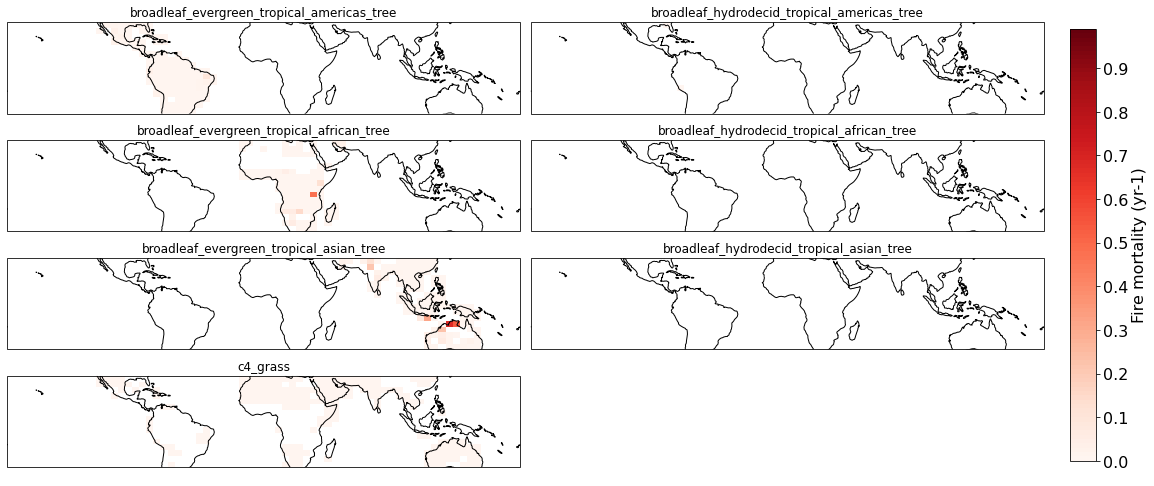

In [49]:
order = [0,2,4,1,3,5,6]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,1.0,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10))
axs=axs.flatten()
for i in range(0,7):
        cs= fmort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds', ax=axs[order[i]],add_colorbar=False)
        axs[order[i]].set_title(pftnames[i])
        axs[order[i]].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Fire mortality (yr-1)', size=16)
cbar.ax.tick_params(labelsize=16)

axs[7].axis('off')

### FIRE DYNAMICS

In [50]:
burnfrac = fates.FATES_BURNFRAC.mean(dim='time') * 86400 * 365
print(burnfrac.shape)

(16, 72)


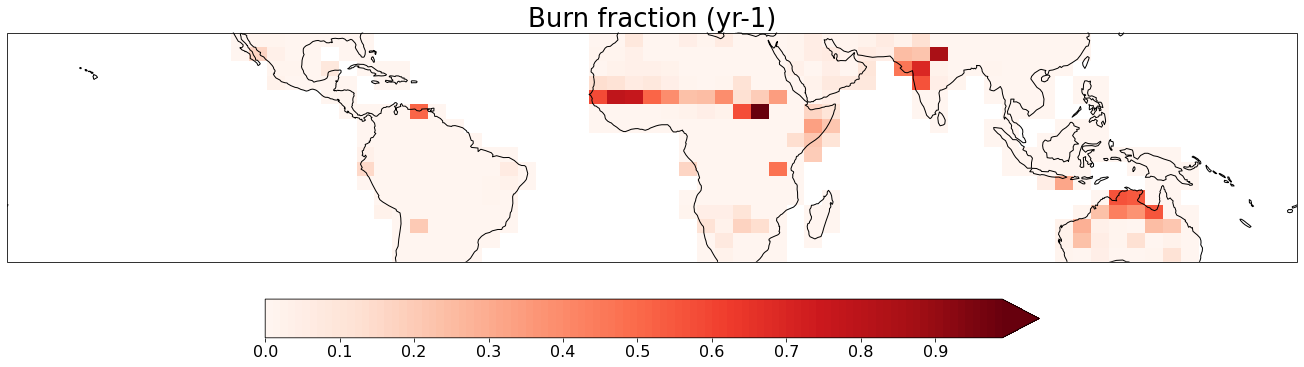

In [51]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,1.0,0.01)
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10), constrained_layout=True)

cs= burnfrac.plot(levels=clevs,cmap='Reds', ax=axs,add_colorbar=False)
axs.set_title('Burn fraction (yr-1)', size=26)
axs.coastlines()

cbar = fig.colorbar(cs, ax=axs, location='bottom',shrink=0.6)
cbar.ax.set_title("")
cbar.ax.tick_params(labelsize=16)


### Canopy area height

In [52]:
ca_ht = fates.FATES_CANOPYAREA_HT.mean(dim='time')
print(ca_ht.shape)

(10, 16, 72)


In [53]:
hts = fates.fates_levheight.values

print(hts)

[ 0.   0.1  0.3  1.   3.  10.  20.  30.  40.  50. ]


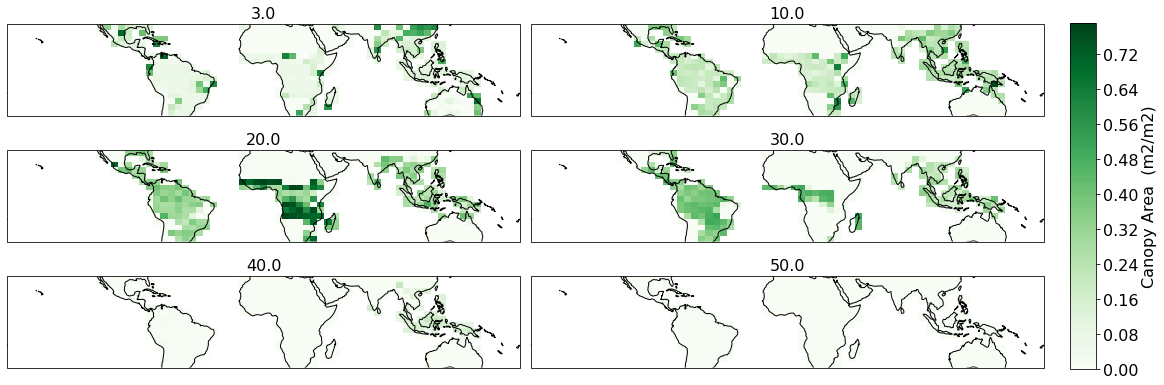

In [58]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,0.8,0.01)
fig, axs = plt.subplots(nrows=3,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8))
axs=axs.flatten()
for i in range(0,6):
        cs= ca_ht.isel(fates_levheight=i+4).plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
        axs[i].set_title(hts[i+4], size=16)
        axs[i].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Canopy Area  (m2/m2)', size=16)
cbar.ax.tick_params(labelsize=16)

Text(0.5, 1.0, 'Difference (m)')

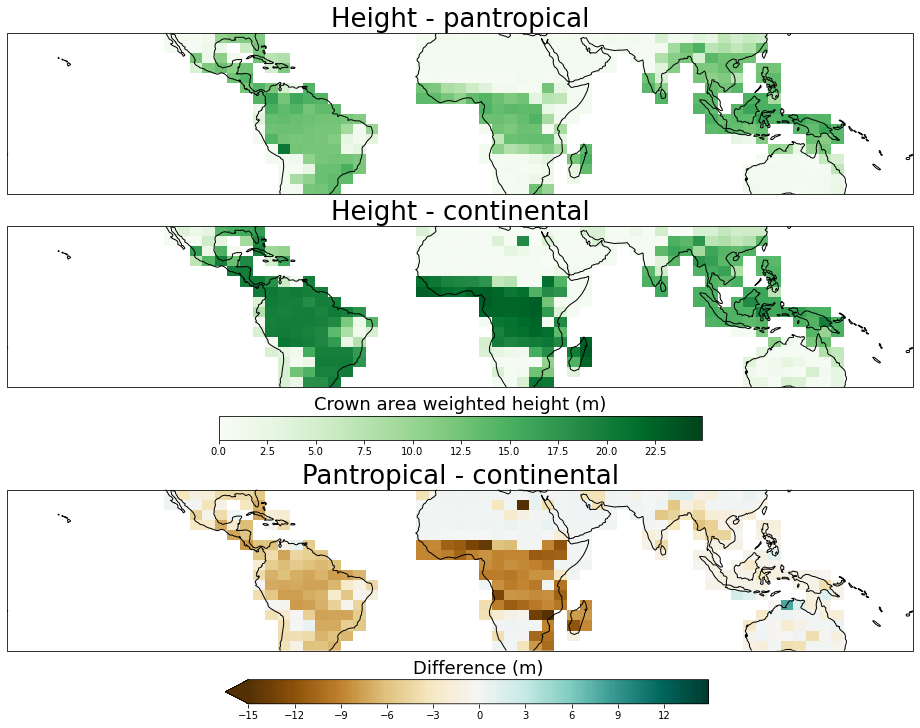

In [56]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,25,0.1)
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10), constrained_layout=True)

axs = axs.flatten()

cs= fates_ctr.FATES_CA_WEIGHTED_HEIGHT.mean(dim='time').plot(levels=clevs,cmap='Greens', ax=axs[0],add_colorbar=False)
axs[0].set_title('Height - pantropical', size=26)
axs[0].coastlines()

cs= fates.FATES_CA_WEIGHTED_HEIGHT.mean(dim='time').plot(levels=clevs,cmap='Greens', ax=axs[1],add_colorbar=False)
axs[1].set_title('Height - continental', size=26)
axs[1].coastlines()

cbar = fig.colorbar(cs, ax=axs[1], location='bottom',shrink=0.6)
cbar.ax.set_title("Crown area weighted height (m)", size=18)

diff = fates_ctr.FATES_CA_WEIGHTED_HEIGHT.mean(dim='time') - fates.FATES_CA_WEIGHTED_HEIGHT.mean(dim='time')

clevs=np.arange(-15,15,0.1)
cs= diff.plot(levels=clevs,cmap='BrBG', ax=axs[2],add_colorbar=False)
axs[2].set_title('Pantropical - continental', size=26)
axs[2].coastlines()

cbar = fig.colorbar(cs, ax=axs[2], location='bottom',shrink=0.6)
cbar.ax.set_title("Difference (m)", size=18)


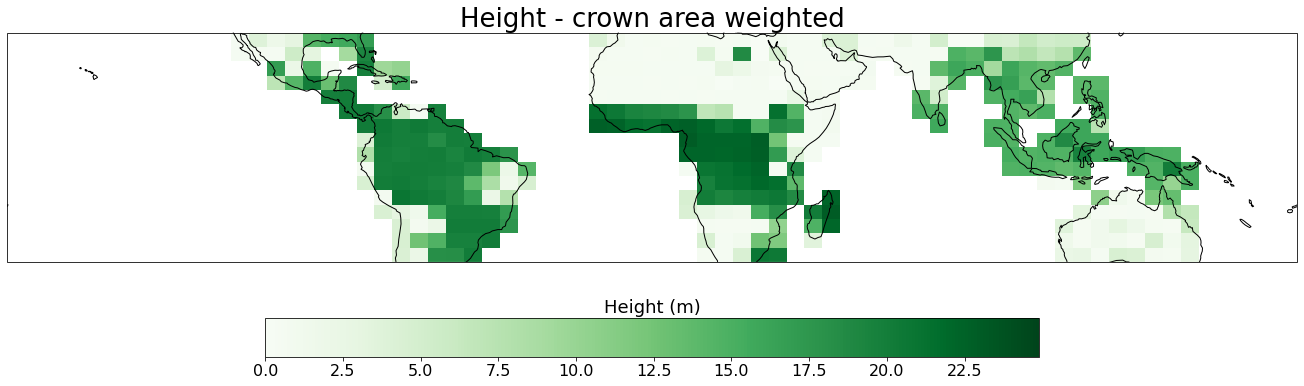

In [57]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,25,0.1)
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10), constrained_layout=True)

cs= fates.FATES_CA_WEIGHTED_HEIGHT.mean(dim='time').plot(levels=clevs,cmap='Greens', ax=axs,add_colorbar=False)
axs.set_title('Height - crown area weighted', size=26)
axs.coastlines()

cbar = fig.colorbar(cs, ax=axs, location='bottom',shrink=0.6)
cbar.ax.set_title("Height (m)", size=18)
cbar.ax.tick_params(labelsize=16)

### Leaf area by height  bins

In [58]:
leaf_ht = fates.FATES_LEAFAREA_HT.mean(dim='time')
print(leaf_ht.shape)

(10, 16, 72)


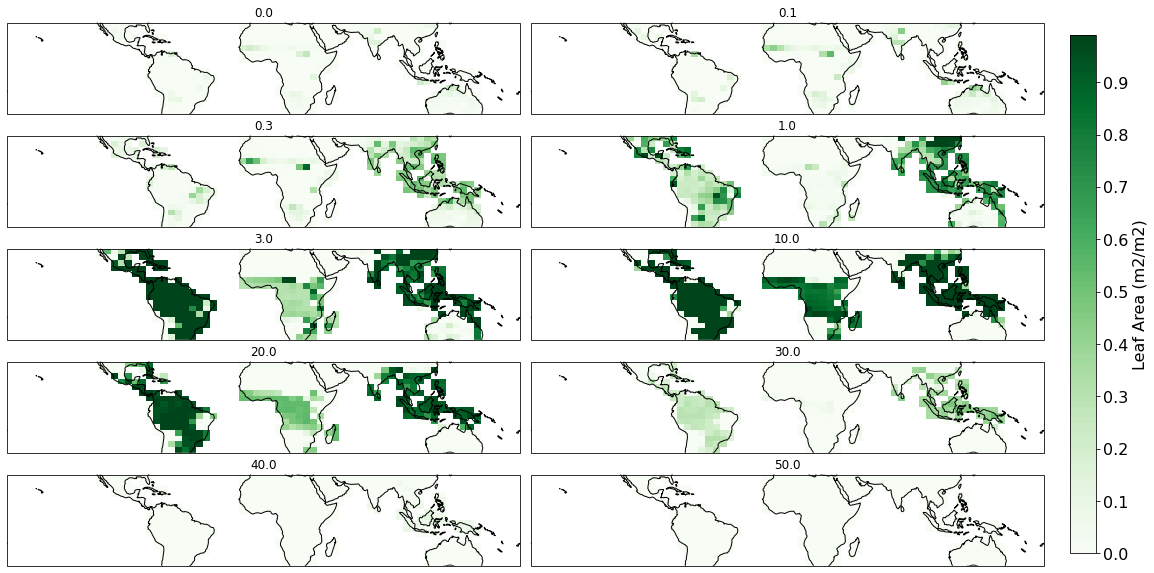

In [59]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,1.0,0.01)
fig, axs = plt.subplots(nrows=5,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,12))
axs=axs.flatten()
for i in range(0,10):
        cs= leaf_ht.isel(fates_levheight=i).plot(levels=clevs,cmap='Greens', ax=axs[i],add_colorbar=False)
        axs[i].set_title(hts[i])
        axs[i].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Leaf Area (m2/m2)', size=16)
cbar.ax.tick_params(labelsize=16)

### Canopy and understory crown area

In [60]:
ca_cl = fates.FATES_CROWNAREA_CL.mean(dim='time')
print(ca_cl.shape)

(2, 16, 72)


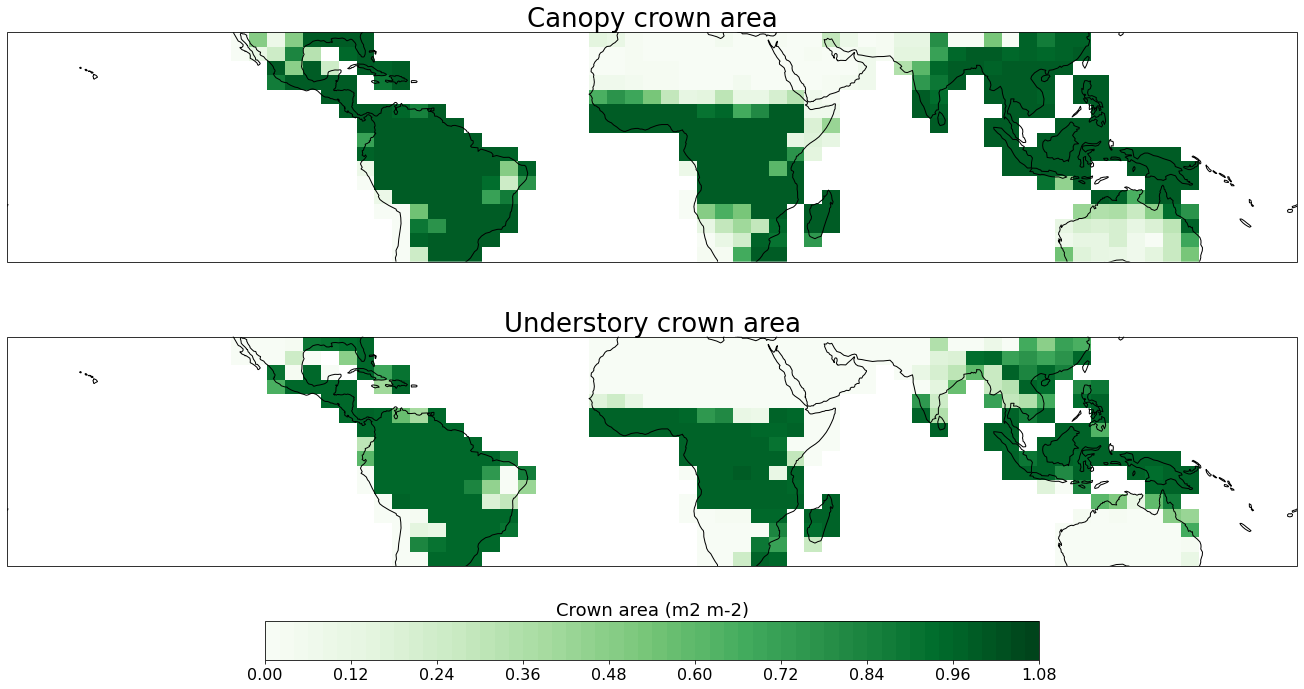

In [61]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,1.1,0.02)
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10), constrained_layout=True)

axs = axs.flatten()

cs= ca_cl.isel(fates_levcan=0).plot(levels=clevs,cmap='Greens', ax=axs[0],add_colorbar=False)
axs[0].set_title('Canopy crown area', size=26)
axs[0].coastlines()

cs= ca_cl.isel(fates_levcan=1).plot(levels=clevs,cmap='Greens', ax=axs[1],add_colorbar=False)
axs[1].set_title('Understory crown area', size=26)
axs[1].coastlines()

cbar = fig.colorbar(cs, ax=axs, location='bottom',shrink=0.6)
cbar.ax.set_title("Crown area (m2 m-2)", size=18)
cbar.ax.tick_params(labelsize=16)

In [62]:
lai_canopy = fates.FATES_LAI_CANOPY_SZ.sum(dim='fates_levscls').mean(dim='time') * fates.FATES_FRACTION.mean(dim='time')
lai_ustory = fates.FATES_LAI_USTORY_SZ.sum(dim='fates_levscls').mean(dim='time') * fates.FATES_FRACTION.mean(dim='time')

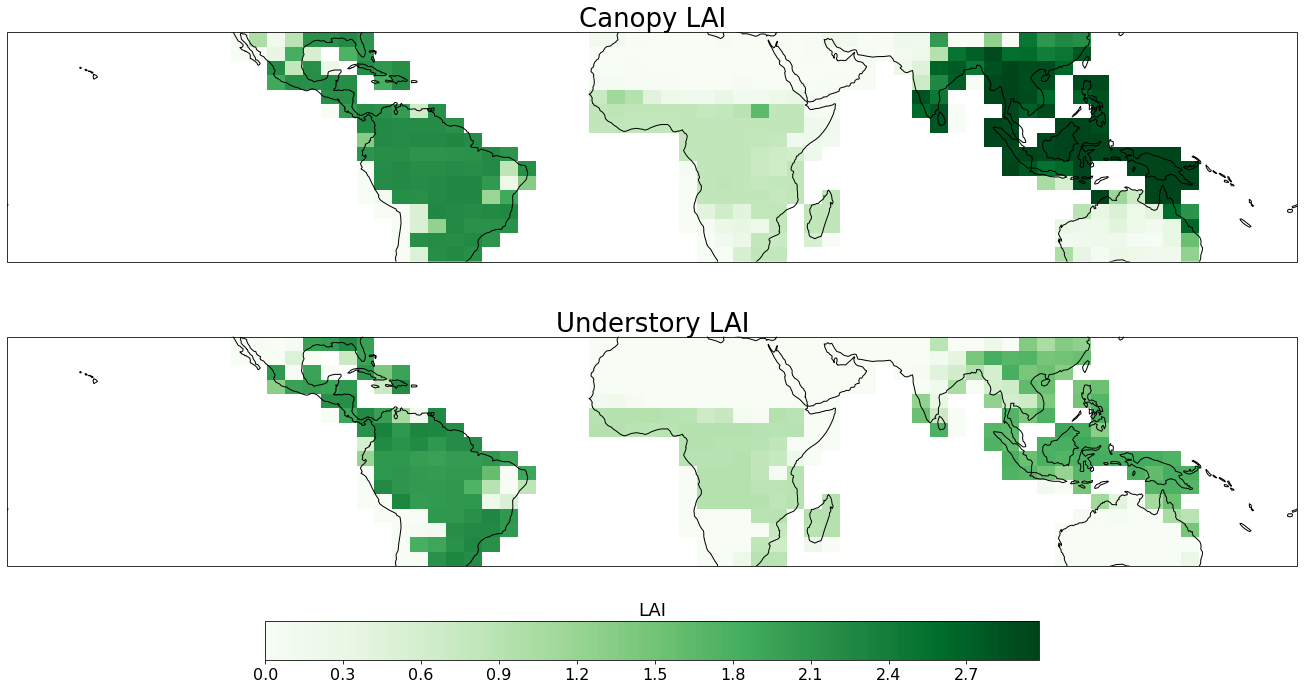

In [63]:
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,3.0,0.02)
fig, axs = plt.subplots(nrows=2,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10), constrained_layout=True)

axs = axs.flatten()

cs= lai_canopy.plot(levels=clevs,cmap='Greens', ax=axs[0],add_colorbar=False)
axs[0].set_title('Canopy LAI', size=26)
axs[0].coastlines()

cs= lai_ustory.plot(levels=clevs,cmap='Greens', ax=axs[1],add_colorbar=False)
axs[1].set_title('Understory LAI', size=26)
axs[1].coastlines()

cbar = fig.colorbar(cs, ax=axs, location='bottom',shrink=0.6)
cbar.ax.set_title("LAI", size=18)
cbar.ax.tick_params(labelsize=16)

### Leaf carbon

In [64]:
leafc_pf = fates.FATES_LEAFC_PF.mean(dim='time')

In [65]:
order = [0,2,4,1,3,5,6]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,0.2,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10))
axs=axs.flatten()
for i in range(0,7):
        cs= leafc_pf.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens', ax=axs[order[i]],add_colorbar=False)
        axs[order[i]].set_title(pftnames[i])
        axs[order[i]].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('veg C (kg C m-2)', size=16)
cbar.ax.tick_params(labelsize=16)

axs[7].axis('off')


(0.0, 1.0, 0.0, 1.0)

In [66]:
gpp_pf = fates.FATES_GPP_PF.mean(dim='time') * 86400 * 365  * fates.FATES_FRACTION.mean(dim='time')

(0.0, 1.0, 0.0, 1.0)

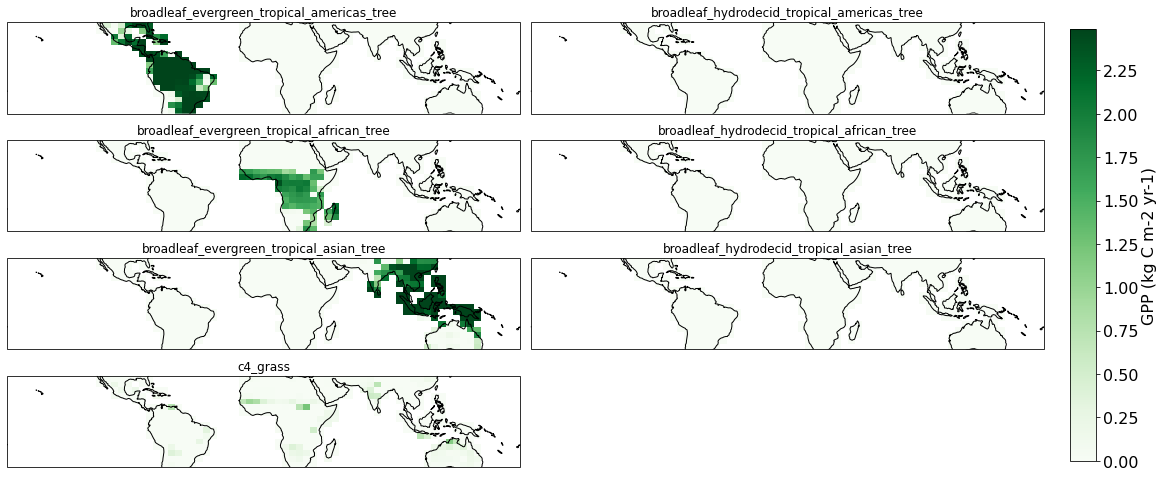

In [67]:
order = [0,2,4,1,3,5,6]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,2.5,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10))
axs=axs.flatten()
for i in range(0,7):
        cs= gpp_pf.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens', ax=axs[order[i]],add_colorbar=False)
        axs[order[i]].set_title(pftnames[i])
        axs[order[i]].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('GPP (kg C m-2 yr-1)', size=16)
cbar.ax.tick_params(labelsize=16)

axs[7].axis('off')

In [68]:
npp_pf = fates.FATES_NPP_PF.mean(dim='time') * 86400 * 365  * fates.FATES_FRACTION.mean(dim='time')

In [69]:
order = [0,2,4,1,3,5,6]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,2.5,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10))
axs=axs.flatten()
for i in range(0,7):
        cs= npp_pf.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens', ax=axs[order[i]],add_colorbar=False)
        axs[order[i]].set_title(pftnames[i])
        axs[order[i]].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('NPP (kg C m-2 yr-1)', size=16)
cbar.ax.tick_params(labelsize=16)

axs[7].axis('off')

(0.0, 1.0, 0.0, 1.0)

### First two years of the simulation 

In [94]:
fates_2  = '/pscratch/sd/j/jneedham/elm_runs/tropical_fb/full_fates_tropical_v3_debug.Ed9fb3dd6d4-Fb96ebacf.2025-05-16/run/full_fates_tropical_v3_debug.Ed9fb3dd6d4-Fb96ebacf.2025-05-16.elm.h0.yr1.nc'
fates_2 = xr.open_dataset(fates_2,  decode_times=False)


In [95]:
cmort = scpf_to_scls_by_pft(fates_2.FATES_MORTALITY_CSTARV_SZPF, fates_2).sum(dim='fates_levscls')
nplant = scpf_to_scls_by_pft(fates_2.FATES_NPLANT_SZPF, fates_2).sum(dim='fates_levscls')

cmort = cmort/nplant
cmort = cmort.mean(dim='time')

print(cmort.shape)

(7, 16, 72)


(0.0, 1.0, 0.0, 1.0)

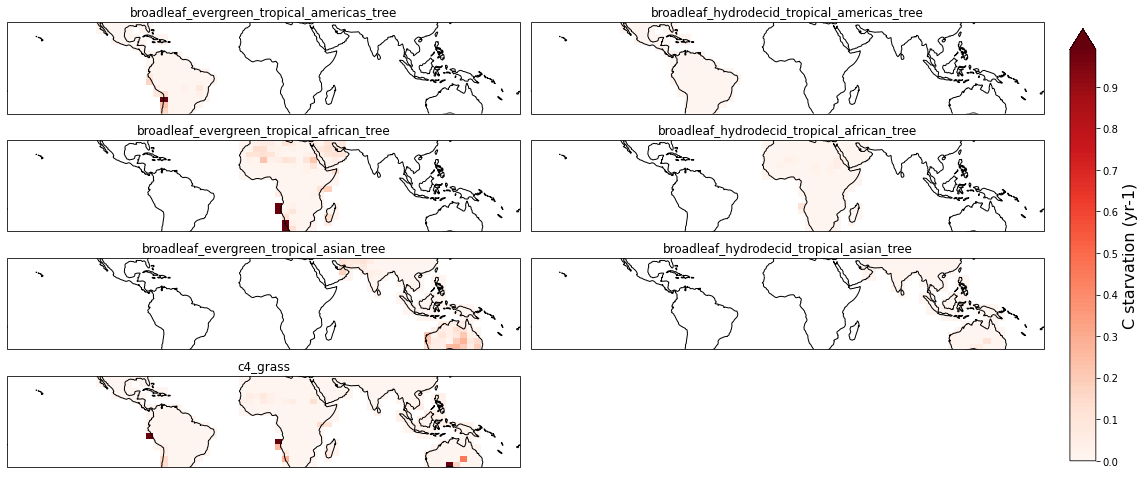

In [96]:
order = [0,2,4,1,3,5,6]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,1.0,0.01)
fig, axs = plt.subplots(nrows=4,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,10))
axs=axs.flatten()
for i in range(0,7):
        cs= cmort.isel(fates_levpft=i).plot(levels=clevs,cmap='Reds', ax=axs[order[i]],add_colorbar=False)
        axs[order[i]].set_title(pftnames[i])
        axs[order[i]].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('C starvation (yr-1)', size=16)

axs[7].axis('off')

In [104]:
recr =  fates_2.FATES_RECRUITMENT_PF.isel(time=slice(0,2)).mean(dim='time')

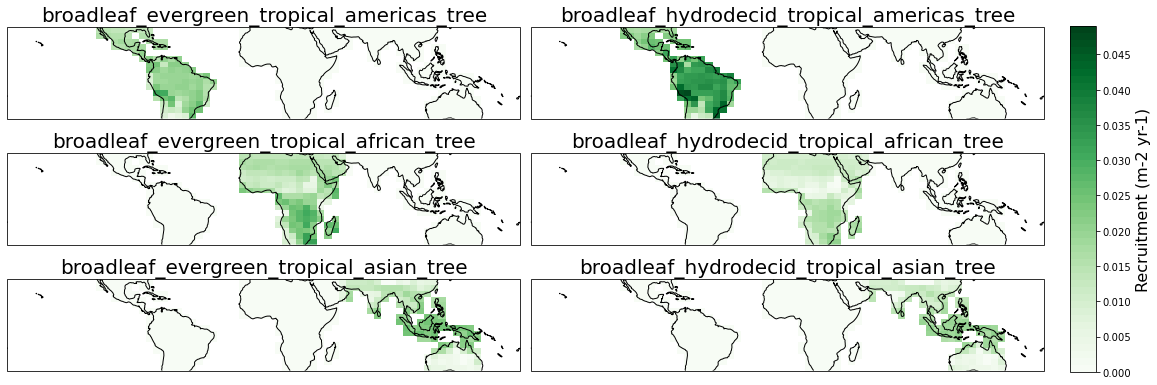

In [107]:
order = [0,2,4,1,3,5,6]
# Define the contour levels to use in plt.contourf
clevs=np.arange(0,0.05,0.001)
fig, axs = plt.subplots(nrows=3,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(18,8))
axs=axs.flatten()
for i in range(0,6):
        cs= recr.isel(fates_levpft=i).plot(levels=clevs,cmap='Greens', ax=axs[order[i]],add_colorbar=False)
        axs[order[i]].set_title(pftnames[i], size=20)
        axs[order[i]].coastlines()

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.03)
cbar_ax = fig.add_axes([0.92, 0.275, 0.02, 0.6])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='vertical')
cbar.set_label('Recruitment (m-2 yr-1)', size=16)

#axs[7].axis('off')